# Amazon Fine Food Reviews Analysis

In [2]:
#Loading the data


%matplotlib inline
import warnings
warnings.filterwarnings("ignore")



import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\anu_m\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
#Reading Data



con = sqlite3.connect('database.sqlite')
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 6000""", con) 


def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (6000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


# Cleaning Data




In [4]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(5979, 10)

In [5]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

99.65

In [6]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [7]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()


(5979, 10)


positive    5014
negative     965
Name: Score, dtype: int64

# text Preprocessing

In [8]:
# Tutorial about Python regular expressions: https://pymotw.com/2/re/

def html(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def punctuation(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer
final_text = []
for index in range(len(final['Text'])):
    filtered_sentence=[]
    sent=html(final['Text'].iloc[index]) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in punctuation(w).split():# clean punctuation marks from words
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):# verifying word must be a alphabet and atleat two character long
                cleaned_words = cleaned_words.lower()
                if(cleaned_words not in stop):# blocks stopwords
                    s=(sno.stem(cleaned_words))# stemming in process
                    filtered_sentence.append(s)
                else:
                    continue
            else:
                continue 
    str1 = " ".join(filtered_sentence) #final cleaned string of words
    final_text.append(str1)

In [9]:
#Here we find out the positive(2500) and negative(2500) values and put them into their respective arrays

pos=0
neg= 0
data_text=[]
data_label = []
for index in range(len(final['Score'])):
    if final['Score'].iloc[index] == 'positive' and pos < 2500:
        data_text.append(final_text[index])
        data_label.append(final['Score'].iloc[index])
        pos+=1
    elif final['Score'].iloc[index] == 'positive' and pos >= 2500:
        continue
    elif final['Score'].iloc[index] == 'negative' and neg < 2500:
        data_text.append(final_text[index])
        data_label.append(final['Score'].iloc[index])
        neg+= 1
    else:
        break

In [10]:
# knowing the shape of label and text
amazon_text = pd.Series(data_text)
amazon_label = pd.Series(data_label)
print(amazon_text.shape)
print(amazon_label.shape)

(3465,)
(3465,)


# BAG OF WORDS

In [11]:
# BAG OF WORDS
count_vect = CountVectorizer() #in scikit-learn
final_counts = count_vect.fit_transform(amazon_text)

final_counts.shape

(3465, 7586)

# [5.1] Applying TNSE on Text BOW vectors

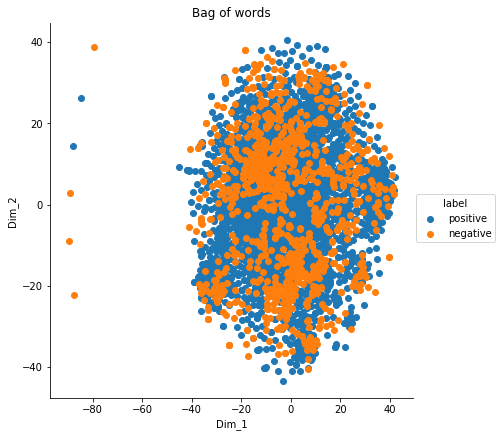

In [12]:
from sklearn.manifold import TSNE
model = TSNE(n_components=2, random_state=0)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000
tsne_data = model.fit_transform(final_counts.toarray())

tsne_data1 = np.vstack((tsne_data.T, amazon_label)).T
tsne_df = pd.DataFrame(data=tsne_data1, columns=("Dim_1", "Dim_2", "label"))
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter,\
                                                'Dim_1', 'Dim_2').add_legend()
plt.title('Bag of words')
plt.show()

From the above graph wee see that it describes the representation of text that tells us the occurence of words within it.

It includes the the words and also the measure of the presence of the words

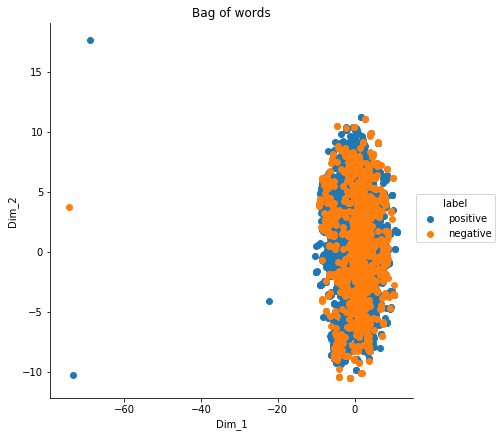

In [16]:
from sklearn.manifold import TSNE
model = TSNE(n_components=2, random_state=0,perplexity=60, n_iter= 2000)
# configuring the parameteres
# the number of components = 2
# default perplexity = 60
# default learning rate = 200
# default Maximum number of iterations for the optimization = 2000
tsne_data = model.fit_transform(final_counts.toarray())

tsne_data1 = np.vstack((tsne_data.T, amazon_label)).T
tsne_df = pd.DataFrame(data=tsne_data1, columns=("Dim_1", "Dim_2", "label"))
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter,\
                                                'Dim_1', 'Dim_2').add_legend()
plt.title('Bag of words')
plt.show()

From the above graph we see that as the perplexity is increased and also the iterations the plots of the graph become more clumsy and more closer to each other

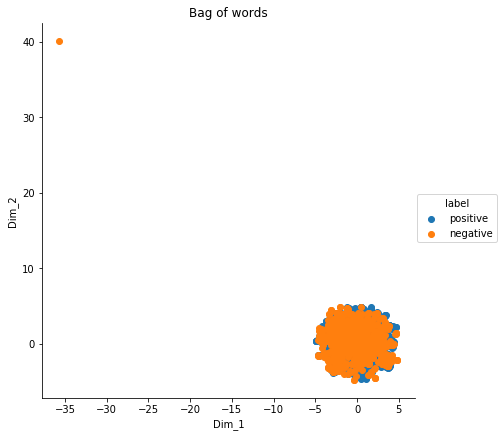

In [17]:
from sklearn.manifold import TSNE
model = TSNE(n_components=2, random_state=0,perplexity=160, n_iter= 3000)
# configuring the parameteres
# the number of components = 2
# default perplexity = 160
# default learning rate = 200
# default Maximum number of iterations for the optimization = 3000
tsne_data = model.fit_transform(final_counts.toarray())

tsne_data1 = np.vstack((tsne_data.T, amazon_label)).T
tsne_df = pd.DataFrame(data=tsne_data1, columns=("Dim_1", "Dim_2", "label"))
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter,\
                                                'Dim_1', 'Dim_2').add_legend()
plt.title('Bag of words')
plt.show()

From the above graph we see that as the perplexity is increased and also the iterations the plots of the graph, it becomes a small ball ie it means that it is not in stable state still

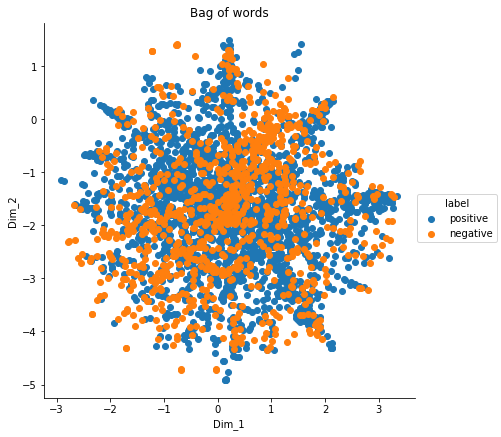

In [18]:
from sklearn.manifold import TSNE
model = TSNE(n_components=2, random_state=0,perplexity=500, n_iter= 5000)
# configuring the parameteres
# the number of components = 2
# default perplexity = 500
# default learning rate = 200
# default Maximum number of iterations for the optimization = 5000
tsne_data = model.fit_transform(final_counts.toarray())

tsne_data1 = np.vstack((tsne_data.T, amazon_label)).T
tsne_df = pd.DataFrame(data=tsne_data1, columns=("Dim_1", "Dim_2", "label"))
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter,\
                                                'Dim_1', 'Dim_2').add_legend()
plt.title('Bag of words')
plt.show()

From the above graph we see that as the perplexity is increased and also the iterations the plots of the graph, we see that we get a stable shape which is more menaingfull 

# TFIDF

In [13]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
final_tf_idf = tf_idf_vect.fit_transform(amazon_text)
final_tf_idf.get_shape()

(3465, 95932)

# [5.2] Applying TNSE on Text TFIDF vectors

In [14]:
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000
from sklearn.manifold import TSNE
tf_idf_model = TSNE(n_components=2, random_state=0)
tsne_tf_idf_data = tf_idf_model.fit_transform(final_tf_idf.toarray())
print("Shape of t-SNE_reduced data = ", tsne_tf_idf_data.shape)
tsne_tf_idf_data1 = np.vstack((tsne_tf_idf_data.T, amazon_label)).T
tsne_tf_idf_df = pd.DataFrame(data=tsne_tf_idf_data1, columns=("Dim_1", "Dim_2",\
                                                               "label"))


Shape of t-SNE_reduced data =  (3465, 2)


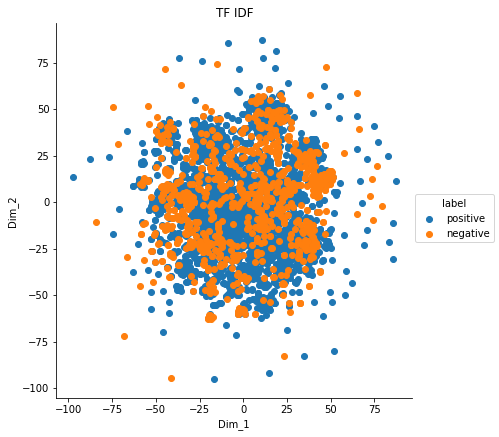

In [15]:
sns.FacetGrid(tsne_tf_idf_df, hue="label", size=6).map(plt.scatter,\
                                                       'Dim_1','Dim_2').add_legend()
plt.title('TF IDF')
plt.show()

From the above graph we see that as the perplexity is increased and also the iterations the plots of the graph, we see that the points are getting closer and closer

In [19]:
# the number of components = 2
# default perplexity = 100
# default learning rate = 200
# default Maximum number of iterations for the optimization = 3000
from sklearn.manifold import TSNE
tf_idf_model = TSNE(n_components=2, random_state=0,perplexity= 100, n_iter= 3000)
tsne_tf_idf_data = tf_idf_model.fit_transform(final_tf_idf.toarray())
print("Shape of t-SNE_reduced data = ", tsne_tf_idf_data.shape)
tsne_tf_idf_data1 = np.vstack((tsne_tf_idf_data.T, amazon_label)).T
tsne_tf_idf_df = pd.DataFrame(data=tsne_tf_idf_data1, columns=("Dim_1", "Dim_2",\
                                                               "label"))


Shape of t-SNE_reduced data =  (3465, 2)


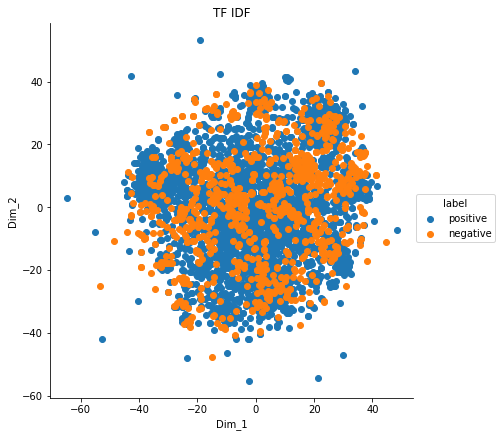

In [20]:
sns.FacetGrid(tsne_tf_idf_df, hue="label", size=6).map(plt.scatter,\
                                                       'Dim_1','Dim_2').add_legend()
plt.title('TF IDF')
plt.show()

From the above graph we see that as the perplexity is increased and also the iterations the plots of the graph, we see that getting more closer

In [21]:
# the number of components = 2
# default perplexity = 400
# default learning rate = 200
# default Maximum number of iterations for the optimization = 4000
from sklearn.manifold import TSNE
tf_idf_model = TSNE(n_components=2, random_state=0,perplexity= 400, n_iter= 4000)
tsne_tf_idf_data = tf_idf_model.fit_transform(final_tf_idf.toarray())
print("Shape of t-SNE_reduced data = ", tsne_tf_idf_data.shape)
tsne_tf_idf_data1 = np.vstack((tsne_tf_idf_data.T, amazon_label)).T
tsne_tf_idf_df = pd.DataFrame(data=tsne_tf_idf_data1, columns=("Dim_1", "Dim_2",\
                                                               "label"))

Shape of t-SNE_reduced data =  (3465, 2)


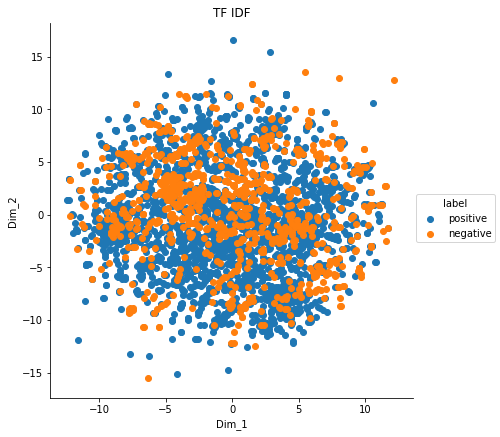

In [22]:
sns.FacetGrid(tsne_tf_idf_df, hue="label", size=6).map(plt.scatter,\
                                                       'Dim_1','Dim_2').add_legend()
plt.title('TF IDF')
plt.show()

From the above graph we see that as the perplexity is increased and also the iterations the plots of the graph, we see that the points have got closer and have gotten farther and have stabalized

# [5.3] Applying TNSE on Text Avg W2V vectors

In [29]:
#First we need to convert the text to word to vec and then to avg word to vec

#WORD2VEC
import re, gensim
i=0
list_of_sent=[]
for sent in amazon_text:
    filtered_sentence=[]
    sent=html(sent)
    for w in sent.split():
        for cleaned_words in punctuation(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent.append(filtered_sentence)
w2v_model=gensim.models.Word2Vec(list_of_sent,min_count=5,size=50, workers=4)


#AVGW2V


# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
    
    
avg_w2v = np.asmatrix(sent_vectors)
avg_w2v.shape    

(3465, 50)

In [31]:
#Aplyying TSNE ON AVGW2V

# the number of components = 2
# default perplexity = 300
# default learning rate = 200
# default Maximum number of iterations for the optimization = 3000

avg_w2v_model = TSNE(n_components=2, random_state=0, perplexity= 300, n_iter= 3000)
tsne_avg_w2v_data = avg_w2v_model.fit_transform(avg_w2v)
print("Shape of t-SNE_reduced data = ", tsne_avg_w2v_data.shape)
# creating a new data frame which help us in ploting the result data
tsne_avg_w2v_data1 = np.vstack((tsne_avg_w2v_data.T, amazon_label)).T
tsne_avg_w2v_df = pd.DataFrame(data=tsne_avg_w2v_data1, columns=("Dim_1",\
                                                                 "Dim_2", "label"))

Shape of t-SNE_reduced data =  (3465, 2)


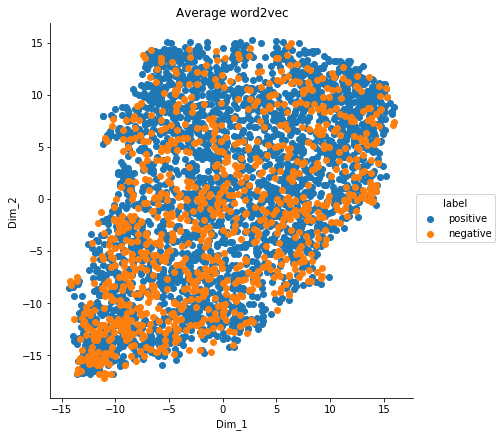

In [32]:
sns.FacetGrid(tsne_avg_w2v_df, hue="label", size=6).map(plt.scatter,\
                                                        'Dim_1', 'Dim_2').add_legend()
plt.title('Average word2vec')
plt.show()

From the above graph we see that as the perplexity is increased and also the iterations the plots of the graph, we see that the points are getting wider and wider

In [35]:
#Aplyying TSNE ON AVGW2V

# the number of components = 2
# default perplexity = 600
# default learning rate = 200
# default Maximum number of iterations for the optimization = 5000

avg_w2v_model = TSNE(n_components=2, random_state=0, perplexity= 600, n_iter= 5000)
tsne_avg_w2v_data = avg_w2v_model.fit_transform(avg_w2v)
print("Shape of t-SNE_reduced data = ", tsne_avg_w2v_data.shape)
# creating a new data frame which help us in ploting the result data
tsne_avg_w2v_data1 = np.vstack((tsne_avg_w2v_data.T, amazon_label)).T
tsne_avg_w2v_df = pd.DataFrame(data=tsne_avg_w2v_data1, columns=("Dim_1",\
                                                                 "Dim_2", "label"))

Shape of t-SNE_reduced data =  (3465, 2)


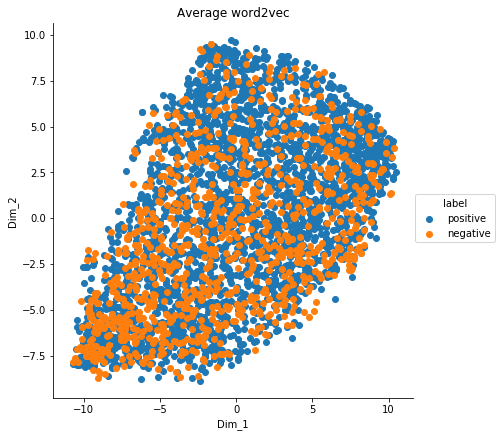

In [36]:
sns.FacetGrid(tsne_avg_w2v_df, hue="label", size=6).map(plt.scatter,\
                                                        'Dim_1', 'Dim_2').add_legend()
plt.title('Average word2vec')
plt.show()

From the above graph we see that as the perplexity is increased and also the iterations the plots of the graph, we see that the points have stabalized

Unlike above two alogorithms it converts the whole sentence into vectors.It assumes all words have same weightage.

# [5.4] Applying TNSE on Text TFIDF weighted W2V vectors

In [37]:
# TF-IDF weighted Word2Vec
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
final_tf_idf = tf_idf_vect.fit_transform(amazon_text)
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf
tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1
    
tf_idf_w2v = np.asmatrix(tfidf_sent_vectors)
tf_idf_w2v.shape    

(3465, 50)

In [41]:
#Aplyying TSNE ON Text TFIDF weighted W2V vectors

# the number of components = 2
# default perplexity = 400
# default learning rate = 200
# default Maximum number of iterations for the optimization = 4000

tf_idf_w2v_model = TSNE(n_components=2, random_state=0, perplexity= 400,n_iter= 4000)
tsne_tf_idf_w2v_data = tf_idf_w2v_model.fit_transform(tf_idf_w2v)
print("Shape of t-SNE_reduced data = ", tsne_tf_idf_w2v_data.shape)
# creating a new data frame which help us in ploting the result data
tsne_tf_idf_w2v_data1 = np.vstack((tsne_tf_idf_w2v_data.T, amazon_label)).T
tsne_tf_idf_w2v_df = pd.DataFrame(data=tsne_tf_idf_w2v_data1,columns=("Dim_1",\
                                                                       "Dim_2","label"))


Shape of t-SNE_reduced data =  (3465, 2)


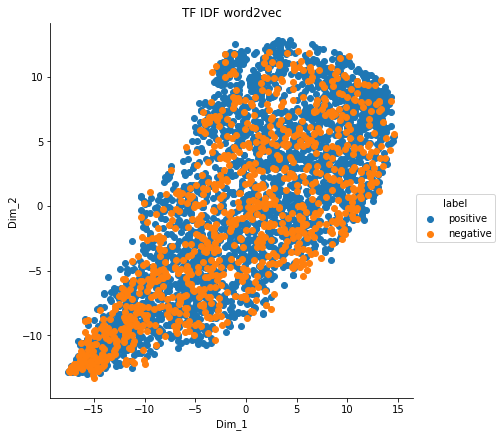

In [42]:
sns.FacetGrid(tsne_tf_idf_w2v_df, hue="label", size=6).map(plt.scatter,'Dim_1',\
                                                           'Dim_2').add_legend()
plt.title('TF IDF word2vec')
plt.show()

From the above graph we see that as the perplexity is increased and also the iterations the plots of the graph, we see that the points are getting closer and closer

In [43]:
#Aplyying TSNE ON Text TFIDF weighted W2V vectors

# the number of components = 2
# default perplexity = 700
# default learning rate = 200
# default Maximum number of iterations for the optimization = 5000

tf_idf_w2v_model = TSNE(n_components=2, random_state=0, perplexity= 700,n_iter= 5000)
tsne_tf_idf_w2v_data = tf_idf_w2v_model.fit_transform(tf_idf_w2v)
print("Shape of t-SNE_reduced data = ", tsne_tf_idf_w2v_data.shape)
# creating a new data frame which help us in ploting the result data
tsne_tf_idf_w2v_data1 = np.vstack((tsne_tf_idf_w2v_data.T, amazon_label)).T
tsne_tf_idf_w2v_df = pd.DataFrame(data=tsne_tf_idf_w2v_data1,columns=("Dim_1",\
                                                                       "Dim_2","label"))


Shape of t-SNE_reduced data =  (3465, 2)


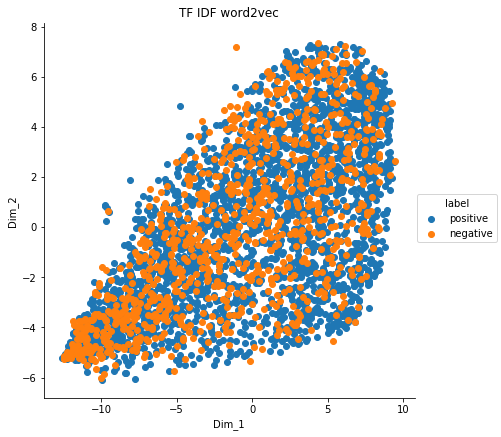

In [44]:
sns.FacetGrid(tsne_tf_idf_w2v_df, hue="label", size=6).map(plt.scatter,'Dim_1',\
                                                           'Dim_2').add_legend()
plt.title('TF IDF word2vec')
plt.show()

It converts the whole sentence into vectors and take words semantics into consideraton.

# [6] Conclusions

The two algos(word2vec and tdidf wrd2vec) are much better than BOW and TF IDF because they remove outliers or less appeared words.

They keep words with same symantics together.

By reducing dimension with t-SNE with diffrent parameters we observe that td-idf wrd2vec has better performance than that of other graphs because it has more clarityy and more grasping.